In [1]:
# Real life data

import logging
import threading
import json
import itertools
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from iotfunctions.bif import PythonExpression
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SimpleRegressor)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
'''
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_schema=None
db = Database(credentials=credentials)
print (db)
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)
'''

db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-09-03T11:21:42.699 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [3]:
date_rng = pd.date_range(start='09/01/2021', end='09/03/2021', freq='5s')
df_input = pd.DataFrame(date_rng, columns=['timestamp'])
df_input['value'] = np.random.randint(0,100,size=(len(date_rng)))
df_input['entity'] = 'myentity'

df_input.set_index(['entity','timestamp'], inplace=True)
df_input.describe()

,value
count,34561.000000
mean,49.687104
std,28.843039
min,0.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,99.000000


In [4]:
df_input2 = df_input.copy()

Indexlist = df_input2.index.to_list()
Indexlist_new = []
for p in Indexlist:
    p_new = ('testentity', p[1])
    Indexlist_new.append(p_new)
df_input2.index = Indexlist_new
df_input = pd.concat([df_input,df_input2])
df_input

value
entity     timestamp                 
myentity   2021-09-01 00:00:00     12
           2021-09-01 00:00:05      6
           2021-09-01 00:00:10     76
           2021-09-01 00:00:15     38
           2021-09-01 00:00:20     95
...                               ...
testentity 2021-09-02 23:59:40      1
           2021-09-02 23:59:45     77
           2021-09-02 23:59:50     19
           2021-09-02 23:59:55     74
           2021-09-03 00:00:00     85

[69122 rows x 1 columns]

In [5]:
# Python expression to turn timestamp into a separate column
EngineLogging.configure_console_logging(logging.ERROR)
pythii = PythonExpression(expression='df.reset_index()["timestamp"].values', output_name='timestamp2')

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = pythii._build_entity_type(columns = [Column('value',Float())], **jobsettings)
pythii._entity_type = et

# allow training and delete existing models

df_input = pythii.execute(df=df_input)

In [6]:
df_input

value          timestamp2
entity     timestamp                                     
myentity   2021-09-01 00:00:00     12 2021-09-01 00:00:00
           2021-09-01 00:00:05      6 2021-09-01 00:00:05
           2021-09-01 00:00:10     76 2021-09-01 00:00:10
           2021-09-01 00:00:15     38 2021-09-01 00:00:15
           2021-09-01 00:00:20     95 2021-09-01 00:00:20
...                               ...                 ...
testentity 2021-09-02 23:59:40      1 2021-09-02 23:59:40
           2021-09-02 23:59:45     77 2021-09-02 23:59:45
           2021-09-02 23:59:50     19 2021-09-02 23:59:50
           2021-09-02 23:59:55     74 2021-09-02 23:59:55
           2021-09-03 00:00:00     85 2021-09-03 00:00:00

[69122 rows x 2 columns]

In [7]:
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())

db_schema = "BLUADMIN"
db2 = Database(credentials=credentials)
print (db2)


In [10]:
table = db2.get_table('BN_SWA')

In [12]:
start_ts = dt.datetime.utcnow() - dt.timedelta(days=50)
end_ts = dt.datetime.utcnow()
df_t = db2.read_table(table, None, None, None, "EVT_TIMESTAMP", start_ts, end_ts)
print (table)

BN_SWA


In [13]:
df_t

,alarmtypecategory,pmid,alarmtypeclassification,alarmtypeid,evt_timestamp,deviceid,devicetype,rcv_timestamp_utc,updated_utc
0,Minor,SA-DRV-000077,Alarm,17.0,2021-08-11 15:08:50.130,KO-SPV-004890,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453
1,Minor,SA-DRV-000078,Alarm,17.0,2021-08-11 15:07:24.260,KO-SPV-004897,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453
2,Minor,SA-DRV-000094,Alarm,17.0,2021-08-11 15:01:01.210,KO-SPV-005360,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453
3,Minor,SA-DRV-000467,Alarm,17.0,2021-08-11 15:08:51.750,KO-SPV-004890,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453
4,Minor,SA-DRV-000901,Alarm,17.0,2021-08-11 15:07:24.310,KO-SPV-004897,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453
...,...,...,...,...,...,...,...,...,...
5497,Minor,SA-DRV-005422,Alarm,25.0,2021-09-03 06:00:01.810,KO-SPV-004906,BN_SWA,2021-09-03 06:15:05.630,2021-09-03 06:15:05.630
5498,Minor,SA-DRV-005422,Alarm,26.0,2021-09-03 06:00:01.810,KO-SPV-004906,BN_SWA,2021-09-03 06:15:05.630,2021-09-03 06:15:05.630
5499,Minor,SA-DRV-005422,Alarm,27.0,2021-09-03 06:00:01.810,KO-SPV-004906,BN_SWA,2021-09-03 06:15:05.630,2021-09-03 06:15:05.630
5500,Minor,SA-DRV-005899,Alarm,17.0,2021-09-03 06:20:54.900,KO-SPV-004937,BN_SWA,2021-09-03 06:30:05.377,2021-09-03 06:30:05.377


In [14]:
# Python expression to multiply alarmtypeid by 2 and save it in column ALT
EngineLogging.configure_console_logging(logging.ERROR)
pythii = PythonExpression(expression='df["alarmtypeid"].values * 2', output_name='ALT')

jobsettings = { 'db': db2, 
               '_db_schema': db_schema, 'save_trace_to_file' : True}
et = pythii._build_entity_type(columns = [Column('value',Float())], **jobsettings)
pythii._entity_type = et

# allow training and delete existing models

df_t = pythii.execute(df=df_t)

In [15]:
df_t

,alarmtypecategory,pmid,alarmtypeclassification,alarmtypeid,evt_timestamp,deviceid,devicetype,rcv_timestamp_utc,updated_utc,ALT
0,Minor,SA-DRV-000077,Alarm,17.0,2021-08-11 15:08:50.130,KO-SPV-004890,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453,34.0
1,Minor,SA-DRV-000078,Alarm,17.0,2021-08-11 15:07:24.260,KO-SPV-004897,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453,34.0
2,Minor,SA-DRV-000094,Alarm,17.0,2021-08-11 15:01:01.210,KO-SPV-005360,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453,34.0
3,Minor,SA-DRV-000467,Alarm,17.0,2021-08-11 15:08:51.750,KO-SPV-004890,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453,34.0
4,Minor,SA-DRV-000901,Alarm,17.0,2021-08-11 15:07:24.310,KO-SPV-004897,BN_SWA,2021-08-11 15:15:05.453,2021-08-11 15:15:05.453,34.0
...,...,...,...,...,...,...,...,...,...,...
5497,Minor,SA-DRV-005422,Alarm,25.0,2021-09-03 06:00:01.810,KO-SPV-004906,BN_SWA,2021-09-03 06:15:05.630,2021-09-03 06:15:05.630,50.0
5498,Minor,SA-DRV-005422,Alarm,26.0,2021-09-03 06:00:01.810,KO-SPV-004906,BN_SWA,2021-09-03 06:15:05.630,2021-09-03 06:15:05.630,52.0
5499,Minor,SA-DRV-005422,Alarm,27.0,2021-09-03 06:00:01.810,KO-SPV-004906,BN_SWA,2021-09-03 06:15:05.630,2021-09-03 06:15:05.630,54.0
5500,Minor,SA-DRV-005899,Alarm,17.0,2021-09-03 06:20:54.900,KO-SPV-004937,BN_SWA,2021-09-03 06:30:05.377,2021-09-03 06:30:05.377,34.0


#### Customer suggested a correlation between vibration and acceleration

so let's try to predict (although correlation tests do not really indicate it)

In [38]:
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.INFO)


gbmii = GBMRegressor(features=features, max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=targets,
                     predictions=predictions)
gbmii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('rms',Float()), Column('accel_speed',Float()),
                                        Column('vibrations',Float())], **jobsettings)
gbmii._entity_type = et

# allow training and delete existing models
gbmii.auto_train = True
gbmii.delete_existing_models = True
df_input = gbmii.execute(df=df_input)

2020-06-16T13:25:50.764 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-16T13:25:50.774 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.04714B6046D5']
2020-06-16T13:25:51.410 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.04714B6046D5 has been deleted from table "BLUADMIN"."KPI_MODEL_STORE"
2020-06-16T13:25:51.411 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-06-16T13:25:52.434 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.04714B6046D5 does not exist in table "BLUADMIN"."KPI_MODEL_STORE"
2020-06-16T13:25:52.436 INFO iotfunctions.base.get_models_for_training load model None
2020-06-16T13:25:52.438 INFO iotfunctions.base.get_models_for_training training required: True  res

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbm',
                 LGBMRegressor(learning_rate=1e-05, max_depth=20,
                               n_estimators=4000, num_leaves=40,
                               verbosity=2))])
2020-06-16T13:29:13.607 INFO iotfunctions.metadata.predict predicted using model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.testentity
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4', 'vib_pred',
       'rms_pred'],
      dtype='object')
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4', 'vib_pred',
       'rms_pred'],
      dtype='object')


[[], [], [], [], []]

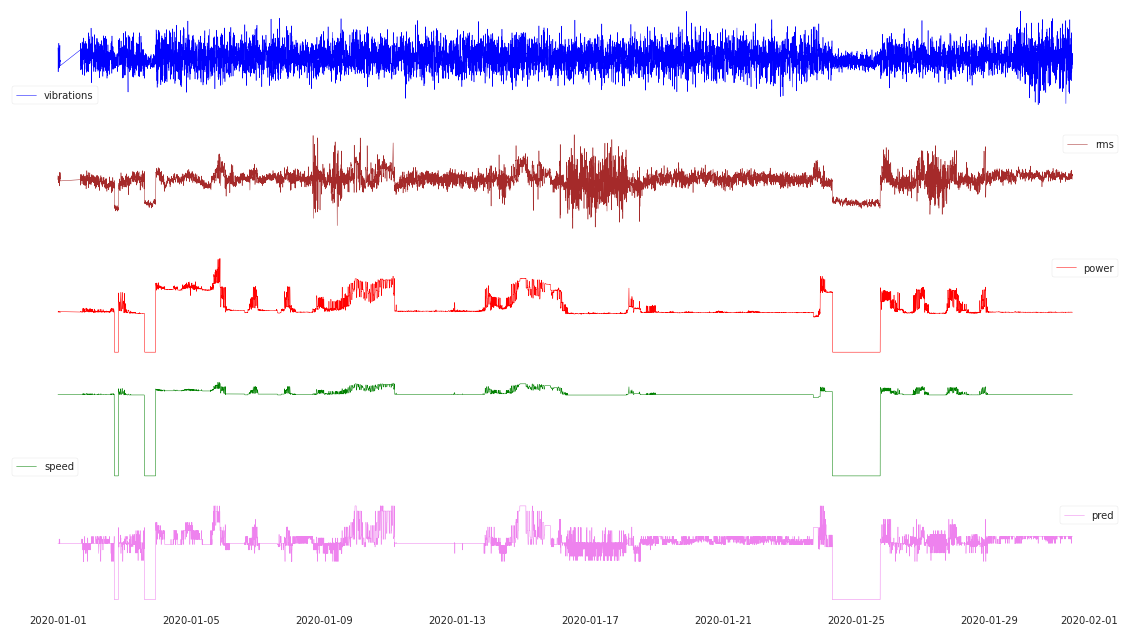

In [39]:
dfg = df_input.loc['04714B6046D5']

fig, ax = plt.subplots(5, 1,figsize=(20,11))

ax[0].plot(dfg.index, dfg['vibrations'], lw=0.5, color='blue', label='vibrations')
ax[1].plot(dfg.index, dfg['rms'], lw=0.5, color='brown', label='rms')
ax[2].plot(dfg.index, dfg['accel_power_0'], lw=0.5, color='red', label='power')
ax[3].plot(dfg.index, dfg['accel_speed'], lw=0.5, color='green', label='speed')
ax[4].plot(dfg.index, dfg['rms_pred'], lw=0.5, color='violet', label='pred')
[ax[i].legend() for i in range(5)]
[ax[i].set_xticks([]) for i in range(4)]
[ax[i].set_yticks([]) for i in range(5)]

In [40]:
modelName = 'model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.04714B6046D5'
lgbm = gbmii.active_models[modelName][0].estimator['gbm']
valid_x = gbmii.active_models[modelName][1]

In [41]:
valid_x

vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B6046D5 2020-01-04 19:52:33.432    3.802626  2.172146  2459.674775   
             2020-01-18 14:50:11.373    3.740334  2.170717  2314.330357   
             2020-01-24 04:34:32.912    3.758585  2.170179  2408.245212   
             2020-01-11 13:18:08.745    3.724011  2.169324  2325.510697   
             2020-01-26 18:54:46.123    3.765858  2.170675  2329.982833   
...                                          ...       ...          ...   
             2020-01-27 16:19:50.877    3.748594  2.168564  2307.622153   
             2020-01-14 16:48:25.398    3.746864  2.169568  2392.592736   
             2020-01-19 22:20:18.275    3.698115  2.171065  2316.566425   
             2020-01-04 03:57:29.824    3.788656  2.171819  2446.258367   
             2020-01-23 00:00:14.297    3.726920  2.170137  2316.566425   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B6046D5 2020-01-04 19:52:33.432         3.8422         3.7914   
             2020-01-18 14:50:11.373         2.2406         2.2454   
             2020-01-24 04:34:32.912         3.4146         3.4270   
             2020-01-11 13:18:08.745         2.3420         2.3364   
             2020-01-26 18:54:46.123         2.3640         2.3840   
...                                             ...            ...   
             2020-01-27 16:19:50.877         2.2468         2.2482   
             2020-01-14 16:48:25.398         2.8016         2.7906   
             2020-01-19 22:20:18.275         2.2390         2.2838   
             2020-01-04 03:57:29.824         3.6274         3.6262   
             2020-01-23 00:00:14.297         2.2484         2.2454   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B6046D5 2020-01-04 19:52:33.432         3.7072         3.7686   
             2020-01-18 14:50:11.373         2.2516         2.2536   
             2020-01-24 04:34:32.912         3.4132         3.4262   
             2020-01-11 13:18:08.745         2.3330         2.3330   
             2020-01-26 18:54:46.123         2.3596         2.3908   
...                                             ...            ...   
             2020-01-27 16:19:50.877         2.2440         2.2380   
             2020-01-14 16:48:25.398         2.7562         2.7836   
             2020-01-19 22:20:18.275         2.2930         2.2624   
             2020-01-04 03:57:29.824         3.7418         3.6648   
             2020-01-23 00:00:14.297         2.2510         2.2498   

                                      accel_power_4 vib_pred rms_pred  
entity       timestamp                                                 
04714B6046D5 2020-01-04 19:52:33.432         3.7802  3.75923  2.17048  
             2020-01-18 14:50:11.373         2.2544  3.75942  2.17042  
             2020-01-24 04:34:32.912         3.3920  3.75923   2.1704  
             2020-01-11 13:18:08.745         2.3288  3.75923  2.17043  
             2020-01-26 18:54:46.123         2.3478  3.75923  2.17043  
...                                             ...      ...      ...  
             2020-01-27 16:19:50.877         2.2196  3.75852  2.17041  
             2020-01-14 16:48:25.398         2.7972  3.75923  2.17044  
             2020-01-19 22:20:18.275         2.2454  3.75896  2.17045  
             2020-01-04 03:57:29.824         3.6618  3.75923  2.17048  
             2020-01-23 00:00:14.297         2.2520  3.75929  2.17046  

[6896 rows x 10 columns]

In [42]:

shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x[features])


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


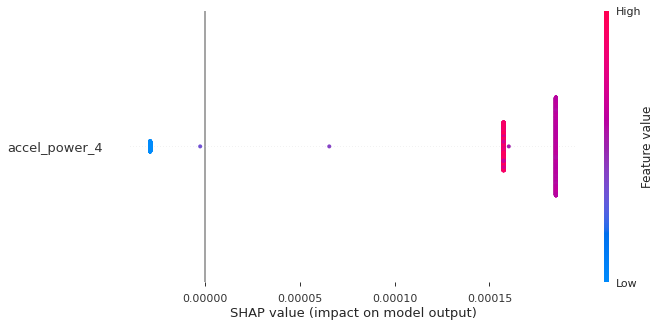

In [43]:
shap.summary_plot(shap_values, valid_x[features], plot_size=(10,5))


In [44]:
shap.dependence_plot("accel_speed", shap_values, valid_x[features])

ValueError: Could not find feature named: accel_speed

In [ ]:
#shap.force_plot("accel_power_1", shap_values, valid_x[['accel_power_0','accel_power_1']])
shap.initjs()
test_x = valid_x[features]

test_sample = test_x.iloc[:1000,:]
shap_values_sample = shap.TreeExplainer(lgbm).shap_values(test_sample)
shap.force_plot(shap.TreeExplainer(lgbm).expected_value, shap_values_sample, test_sample,
                link="identity", figsize=(10,4))

In [55]:
print (gbmii._entity_type.db.model_store)

In [12]:
gbmii = GBMRegressor(features=['accel_power_0','accel_power_1'], max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
gbmii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                        Column('vibrations',Float())], **jobsettings)
gbmii._entity_type = et

# disallow training and preserve existing models for predict
gbmii.auto_train = False
gbmii.delete_existing_models = False
df_input = gbmii.execute(df=df_input)

2020-03-30T17:38:30.568 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-03-30T17:38:30.569 DEBUG iotfunctions.util.__init__ Starting trace
2020-03-30T17:38:30.570 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMRegressor_20200330153830
2020-03-30T17:38:30.570 DEBUG iotfunctions.util.__init__ auto_save None
2020-03-30T17:38:30.571 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-03-30T17:38:30.572 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T17:38:30.573 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMREGRESSOR
Functions:
Granularities:
No schedules metadata
2020-03-30T17:38:30.575 DEBUG mmfunctions.anomaly.execute ['04714B6046D5' 'testentity']
2020-03-30T17:38:30.579 INFO iotfunctions.base.get_models_for_training predic

In [15]:
# Run Monitoring's anomaly detector functions
# EngineLogging.configure_console_logging(logging.DEBUG)

simpleii = SimpleRegressor(features=['accel_power_0','accel_power_1'], # max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
simpleii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = simpleii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                            Column('vibrations',Float())], **jobsettings)
simpleii._entity_type = et

# allow training and delete existing models
simpleii.auto_train = True
simpleii.delete_existing_models = True
df_input = simpleii.execute(df=df_input)

2020-03-30T19:17:29.485 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T19:17:29.494 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5']
2020-03-30T19:17:29.981 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 has been deleted from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:29.984 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-03-30T19:17:30.782 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 does not exist in table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:30.783 INFO iotfunctions.base.get_models_for_training load model None
2020-03-30T19:17:30.784 INFO iotfunctions.base.get_models_for_training training r

/home/markus/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


2020-03-30T19:17:34.760 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been stored in table "BLUADMIN"."KPI_MODEL_STORE".
2020-03-30T19:17:34.761 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5
2020-03-30T19:17:35.555 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been retrieved from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:35.558 INFO iotfunctions.metadata.predict predicted using model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4', 'rms_pred'],
      dtype='object')
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_p

/home/markus/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


2020-03-30T19:17:42.701 INFO iotfunctions.base.find_best_model Trained model no: 0
2020-03-30T19:17:42.748 INFO iotfunctions.base.find_best_model Trained model no: 0 score:0.5410548785172714
2020-03-30T19:17:42.762 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity with evaluation metric value 0.4745025856970637
2020-03-30T19:17:42.775 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity with evaluation metric value 0.4745025856970637
2020-03-30T19:17:47.517 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity of size 928905 bytes has been stored in table "BLUADMIN"."KPI_MODEL_STORE".
2020-03-30T19:17:47.518 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity
2020-03-30T19:17:58.372 INFO iotfunctions.dbtables.retrieve_model Mo

In [16]:

simpleii = SimpleRegressor(features=['accel_power_0','accel_power_1'], # max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
simpleii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = simpleii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                            Column('vibrations',Float())], **jobsettings)
simpleii._entity_type = et

# disallow training and preserve existing models for predict
simpleii.auto_train = False
simpleii.delete_existing_models = False
df_input = simpleii.execute(df=df_input)


2020-03-30T19:21:16.718 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T19:21:16.722 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-03-30T19:21:17.523 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been retrieved from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:21:17.525 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5",
 "target": "rms",
 "features": [
  "accel_power_0",
  "accel_power_1"
 ],
 "estimator_name": "sgd_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": -1.0187012829267998,
 "eval_metric_test": -1.0230987986948104,
 "trained_date": "2020-03-30T17:17:34.254244",
 "expiry_date": null
}
2020-03-30T19:21:17.525 INFO iotfun